In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima.model import ARIMA
register_matplotlib_converters()
from time import time

In [10]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

In [11]:
production_ice_cream = pd.read_csv('ice_cream.csv', parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

In [12]:
production_ice_cream.rename('production', inplace = True)

DATE
1972-01-01     59.9622
1972-02-01     67.0605
1972-03-01     74.2350
1972-04-01     78.1120
1972-05-01     84.7636
                ...   
2019-09-01    100.1741
2019-10-01     90.1684
2019-11-01     79.7223
2019-12-01     75.7094
2020-01-01     83.6290
Name: production, Length: 577, dtype: float64

In [13]:
production_ice_cream = production_ice_cream.asfreq(pd.infer_freq(production_ice_cream.index))

In [14]:
start_date = pd.to_datetime('2010-01-01')
production_ice_cream=production_ice_cream[start_date:]

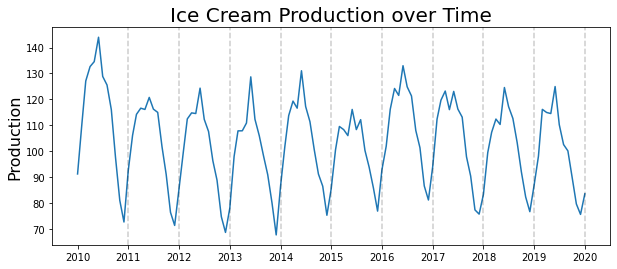

In [15]:
plt.figure(figsize=(10,4))
plt.plot(production_ice_cream)
plt.title('Ice Cream Production over Time', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(2011,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

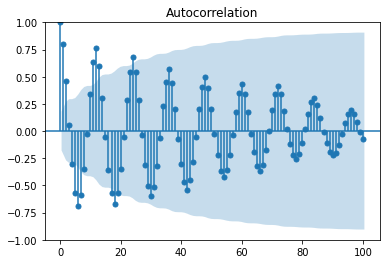

In [16]:
acf_plot = plot_acf(production_ice_cream,lags = 100)

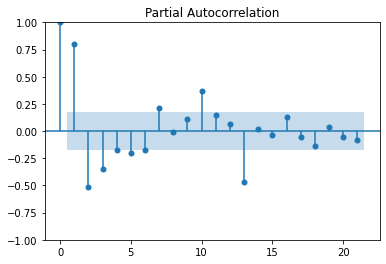

In [17]:
pacf_plot = plot_pacf(production_ice_cream, method='ywm')

In [19]:
train_end = datetime(2016,12,1)
test_end = datetime(2019,12,1)

train_data = production_ice_cream[:train_end]
test_data = production_ice_cream[train_end + timedelta(days=1):test_end]

In [21]:
import statsmodels.api as sm
model=ARIMA(train_data,order=(3,0,0))
results=model.fit()

In [22]:
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:',end - start)

Model Fitting Time: 0.09308671951293945


In [23]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             production   No. Observations:                   84
Model:                 ARIMA(3, 0, 0)   Log Likelihood                -294.008
Date:                Fri, 26 Nov 2021   AIC                            598.015
Time:                        20:57:35   BIC                            610.169
Sample:                    01-01-2010   HQIC                           602.901
                         - 12-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        103.5071      2.531     40.893      0.000      98.546     108.468
ar.L1          1.0488      0.116      9.046      0.000       0.822       1.276
ar.L2         -0.0532      0.204     -0.260      0.7

In [25]:
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]
test_data.index[0],test_data.index[-1],

(Timestamp('2017-01-01 00:00:00', freq='MS'),
 Timestamp('2019-12-01 00:00:00', freq='MS'))

In [26]:
predictions = model_fit.predict(start=pred_start_date,end = pred_end_date)
residuals = test_data - predictions

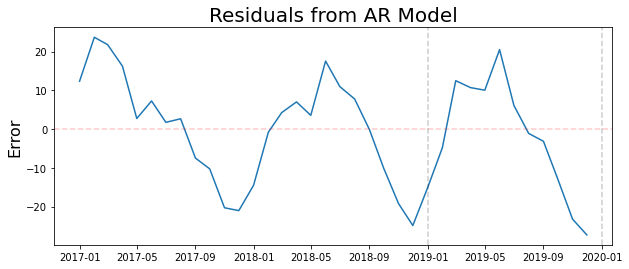

In [27]:
plt.figure(figsize =(10,4))
plt.plot(residuals)
plt.title("Residuals from AR Model",fontsize=20)
plt.ylabel('Error',fontsize=16)
plt.axhline(0, color ="r",linestyle="--",alpha=0.2)
for year in range (2019,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'),color='k',linestyle="--",alpha=0.2)

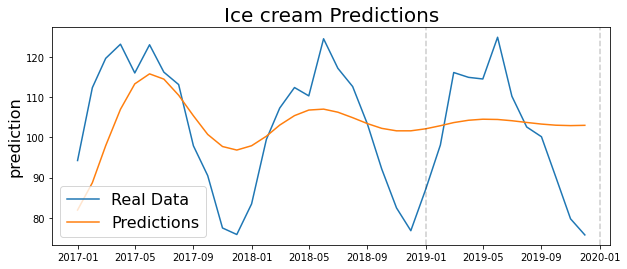

In [28]:
plt.figure(figsize=(10,4))

plt.plot(test_data)
plt.plot(predictions)

plt.legend(('Real Data', 'Predictions'), fontsize=16)

plt.title('Ice cream Predictions', fontsize=20)
plt.ylabel('prediction', fontsize=16)
for year in range (2019,2021):
     plt.axvline(pd.to_datetime(str(year)+'-01-01'),color='k',linestyle="--",alpha=0.2)

In [71]:
#Rolling Forecast Origin
predictions_rolling = pd.Series(dtype='float64')
for end_date in test_data.index:
    train_data = production_ice_cream[:end_date]
    model = ARIMA(train_data,order=(3,0,0))
    model_fit = model.fit()
    pred = model_fit.predict(end_date)
    predictions_rolling.loc[end_date]=pred.loc[end_date]

In [72]:
production_ice_cream[:end_date],production_ice_cream[:end_date-timedelta(days=1)]

(DATE
 2010-01-01     91.2895
 2010-02-01    110.4994
 2010-03-01    127.0971
 2010-04-01    132.6468
 2010-05-01    134.5576
                 ...   
 2019-08-01    102.6085
 2019-09-01    100.1741
 2019-10-01     90.1684
 2019-11-01     79.7223
 2019-12-01     75.7094
 Freq: MS, Name: production, Length: 120, dtype: float64,
 DATE
 2010-01-01     91.2895
 2010-02-01    110.4994
 2010-03-01    127.0971
 2010-04-01    132.6468
 2010-05-01    134.5576
                 ...   
 2019-07-01    110.2632
 2019-08-01    102.6085
 2019-09-01    100.1741
 2019-10-01     90.1684
 2019-11-01     79.7223
 Freq: MS, Name: production, Length: 119, dtype: float64)

In [73]:
end_date

Timestamp('2019-12-01 00:00:00', freq='MS')

In [74]:
predictions_rolling.loc[end_date]

80.71863505143892

In [75]:
pred.loc[end_date]

80.71863505143892

In [76]:
residuals_rolling = test_data-predictions_rolling

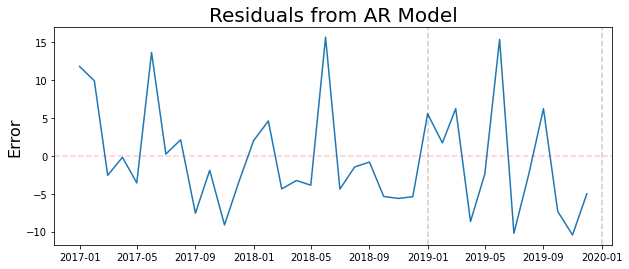

In [77]:
plt.figure(figsize =(10,4))
plt.plot(residuals_rolling)
plt.title("Residuals from AR Model",fontsize=20)
plt.ylabel('Error',fontsize=16)
plt.axhline(0, color ="r",linestyle="--",alpha=0.2)
for year in range (2019,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'),color='k',linestyle="--",alpha=0.2)

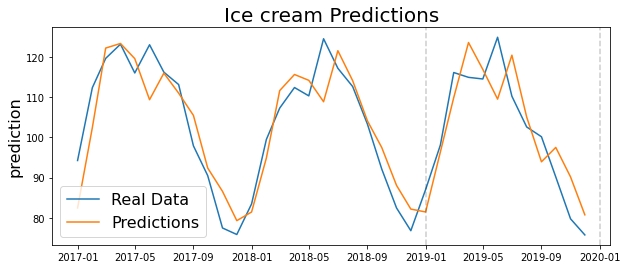

In [78]:
plt.figure(figsize=(10,4))

plt.plot(test_data)
plt.plot(predictions_rolling)

plt.legend(('Real Data', 'Predictions'), fontsize=16)

plt.title('Ice cream Predictions', fontsize=20)
plt.ylabel('prediction', fontsize=16)
for year in range (2019,2021):
     plt.axvline(pd.to_datetime(str(year)+'-01-01'),color='k',linestyle="--",alpha=0.2)